In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2
from skimage.segmentation import felzenszwalb
import numpy as np

### Load the Dataset

In [2]:
healthy_dir = './tree_segmentation_data/healthy'
sick_dir = './tree_segmentation_data/sick'

In [3]:
# Initialize lists to store file information
file_list = []
labels = []

print(f'Healthy images: {len(os.listdir(healthy_dir))}')
print(f'Sick images: {len(os.listdir(sick_dir))}')

# Iterate through healthy images
for filename in os.listdir(healthy_dir):
    if filename.endswith('.JPG'):
        file_list.append(os.path.join(healthy_dir, filename))
        labels.append('healthy')

# Iterate through sick images
for filename in os.listdir(sick_dir):
    if filename.endswith('.JPG'):
        file_list.append(os.path.join(sick_dir, filename))
        labels.append('sick')

# Create a DataFrame to store the data
data = pd.DataFrame({'file_path': file_list, 'label': labels})

# Calculate the number of observations
total_observations = len(data)

# Calculate the number of unique observations
unique_observations = data['file_path'].nunique()

# Display the summary
print(f"Total Observations: {total_observations}")
print(f"Unique Observations: {unique_observations}")

Healthy images: 45
Sick images: 28
Total Observations: 73
Unique Observations: 73


In [4]:
print(data.head())

                                       file_path    label
0  ./tree_segmentation_data/healthy/DJI_0077.JPG  healthy
1  ./tree_segmentation_data/healthy/DJI_0079.JPG  healthy
2  ./tree_segmentation_data/healthy/DJI_0030.JPG  healthy
3  ./tree_segmentation_data/healthy/DJI_0082.JPG  healthy
4  ./tree_segmentation_data/healthy/DJI_0028.JPG  healthy


## EDA

### Bar Chart to visualize the distribution of Healthy and Sick Trees

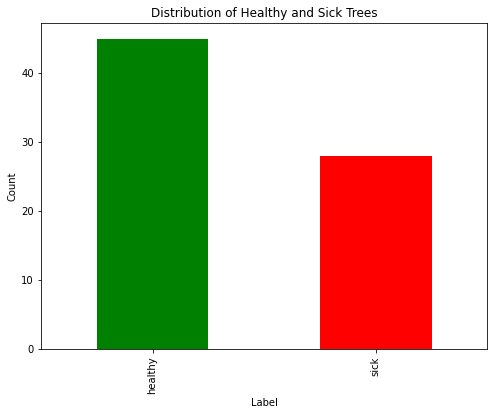

In [5]:
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribution of Healthy and Sick Trees")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Visualize Sample Images

Text(0.5, 1.0, 'Sick')

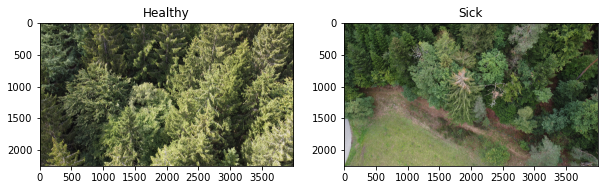

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(plt.imread(data.loc[data['label'] == 'healthy','file_path'][0]))
axes[0].set_title('Healthy')
axes[1].imshow(plt.imread(data.loc[data['label'] == 'sick','file_path'][72]))
axes[1].set_title('Sick')

### Histogram of pixel intensities

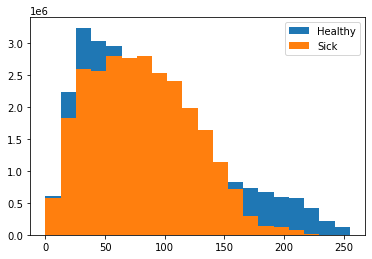

In [7]:
healthy_pixels = plt.imread(data.loc[data['label'] == 'healthy','file_path'][0]).flatten()
sick_pixels = plt.imread(data.loc[data['label'] == 'sick','file_path'][72]).flatten()

plt.hist(healthy_pixels, bins=20, label='Healthy')
plt.hist(sick_pixels, bins=20, label='Sick')
plt.legend()

### Comparing edge distributions

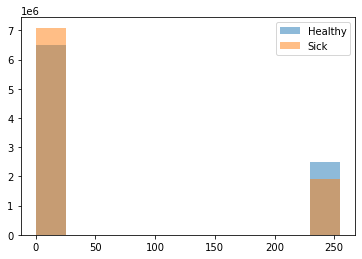

In [8]:
healthy_img = plt.imread(data.loc[data['label'] == 'healthy','file_path'][0])
sick_img = plt.imread(data.loc[data['label'] == 'sick','file_path'][72])

# Edge detection
healthy_edges = cv2.Canny(healthy_img, 100, 200)
sick_edges = cv2.Canny(sick_img, 100, 200)

# Plot edge histogram
plt.hist(healthy_edges.ravel(), label='Healthy', alpha=0.5)
plt.hist(sick_edges.ravel(), label='Sick', alpha=0.5)
plt.legend()

### Load libraries for modeling

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

### Define transformations for image preprocessing

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

### Define model

In [11]:
def load_image(img_path):
    try:
        image = Image.open(img_path)
        return image
    except Exception as e:
        print(f"Error loading image from {img_path}: {e}")
        return None

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        label = 1 if self.dataframe.iloc[idx]['label'] == 'sick' else 0  # Convert labels to 0 (healthy) or 1 (sick)

        # Load the image
        image = load_image(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create dataset

In [15]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
train_dataset = CustomDataset(train_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Train the logistic regression model

In [18]:
input_size = 3 * 224 * 224
model = LogisticRegressionModel(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [19]:
num_epochs = 15
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Flatten the images
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images.float())
        loss = criterion(outputs, labels.float().view(-1, 1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    ep = (epoch + 1)
    print("Epoch [{}], Loss: {:.2f}".format(ep,loss.item()))

Epoch [1], Loss: 1.63
Epoch [2], Loss: 3.42
Epoch [3], Loss: 0.89
Epoch [4], Loss: 1.66
Epoch [5], Loss: 0.96
Epoch [6], Loss: 1.92
Epoch [7], Loss: 0.76
Epoch [8], Loss: 0.58
Epoch [9], Loss: 0.77
Epoch [10], Loss: 0.85
Epoch [11], Loss: 0.63
Epoch [12], Loss: 0.80
Epoch [13], Loss: 0.75
Epoch [14], Loss: 1.99
Epoch [15], Loss: 0.38


### Evaluate the logistic regression model

In [20]:
# Evaluate the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        # Flatten the images
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images.float())
        predictions = (outputs >= 0.5).float()  # Convert to binary predictions
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [21]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 86.67%


In [22]:
# Calculate error rate
error_rate = 1.0 - accuracy

print(f'Test Error Rate: {error_rate:.2%}')

Test Error Rate: 13.33%


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

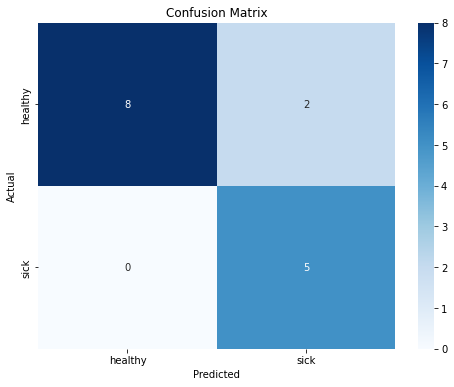

In [24]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=['healthy', 'sick']))

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      0.80      0.89        10
        sick       0.71      1.00      0.83         5

    accuracy                           0.87        15
   macro avg       0.86      0.90      0.86        15
weighted avg       0.90      0.87      0.87        15



In [26]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

Weighted F1 Score: 0.8704


### Train the CNN model

In [27]:
model1 = CNNModel()
model1

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

In [29]:
epochs = 10
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Forward pass
        outputs = model1(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print (f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

Epoch [1], Loss: 1.4882
Epoch [2], Loss: 0.6830
Epoch [3], Loss: 0.6116
Epoch [4], Loss: 0.5944
Epoch [5], Loss: 0.4739
Epoch [6], Loss: 0.4867
Epoch [7], Loss: 0.4568
Epoch [8], Loss: 0.3724
Epoch [9], Loss: 0.2685
Epoch [10], Loss: 0.2960


In [30]:
#Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())

    print('Test Accuracy: {} %'.format(100 * correct / total))
    print('Test Error Rate: {} %'.format(100 * (1 - correct/total)))

Test Accuracy: 100.0 %
Test Error Rate: 0.0 %


In [31]:
cm = confusion_matrix(all_labels, all_preds)

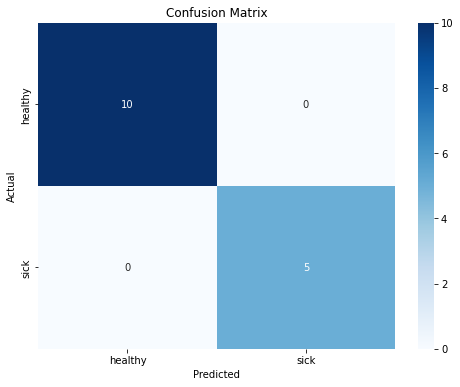

In [32]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['healthy', 'sick'], yticklabels=['healthy', 'sick'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=['healthy', 'sick']))

Classification Report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        10
        sick       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [34]:
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

Weighted F1 Score: 1.0000


In [35]:
nmi = normalized_mutual_info_score(all_labels, all_preds)
print(f'Normalized Mutual Information: {nmi:.4f}')

Normalized Mutual Information: 1.0000


### Prediction for 3 cases of interest using cnn

Actual value: healthy
Predicted value:  healthy


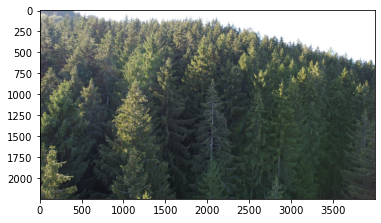

In [36]:
img_path = './tree_segmentation_data/healthy/DJI_0028.JPG'
label = 0

# Load the image
image = load_image(img_path)
plt.imshow(image)

if transform:
    image = transform(image)
    
with torch.no_grad():
    output = model1(image)
    _, predicted = torch.max(output.data, 1)
    
print("Actual value: healthy")
print("Predicted value: ",'healthy' if predicted == 0 else 'sick')

Actual value: healthy
Predicted value:  sick


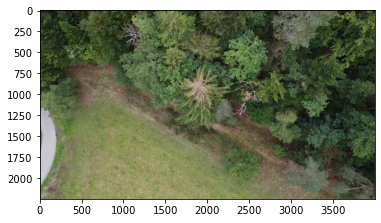

In [37]:
img_path = './tree_segmentation_data/sick/DJI_0061.JPG'
label = 1

# Load the image
image = load_image(img_path)
plt.imshow(image)

if transform:
    image = transform(image)
    
with torch.no_grad():
    output = model1(image)
    _, predicted = torch.max(output.data, 1)
    
print("Actual value: healthy")
print("Predicted value: ",'healthy' if predicted == 0 else 'sick')

Actual value: healthy
Predicted value:  healthy


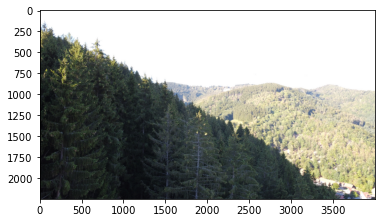

In [40]:
img_path = './tree_segmentation_data/healthy/DJI_0029.JPG'
label = 0

# Load the image
image = load_image(img_path)
plt.imshow(image)

if transform:
    image = transform(image)
    
with torch.no_grad():
    output = model1(image)
    _, predicted = torch.max(output.data, 1)
    
print("Actual value: healthy")
print("Predicted value: ",'healthy' if predicted == 0 else 'sick')